In [3]:
# You can set your own libraries search path by adding M2AIA_PATH to your system environment variables
#  - For installed versions of M2aia point to the /path/to/m2aia/installation/bin directory
#  - For compiled versions of M2aia point to the /path/to/m2aia/build/MITK-build/lib directory

# import os
# os.environ["M2AIA_PATH"] = "/home/jtfc/HS/M2aia/m2aia-dev/m2aia-release/MITK-build/lib/"

Example VII - Pixel-wise classification using spatio-spectral strategy
--------------------------------------------------------------------

In this example we show how
- the SpectrumDataset can be configured to generate spatio-spectral samples form one or multiple imzML images
- image artifacts generated by M2aia (centroid lists, labeled images (ROIs), UMAP images) can be loaded and handled along side with your imzML data
- we can load manually defined ROIs into the training of a DL model (to generate batches of samples with labels)
- to generate batches of samples with labels
- a classification model can be trained
- a classification model can be applied to unseen data

In [4]:
#===================================
# 1. Download data
#===================================
from download_helper import DownloadMTBLS2639
test_files = DownloadMTBLS2639([1,2,4])
train_file = DownloadMTBLS2639([3])

In [5]:
import m2aia as m2
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

train_images = []
train_masks = []
test_images = []

# load imzML files
for f in train_file:
    I = m2.ImzMLReader(f)
    I.SetNormalization(m2.m2NormalizationTIC)
    train_images.append(I)

for f in test_files:
    I = m2.ImzMLReader(f)
    I.SetNormalization(m2.m2NormalizationTIC)
    test_images.append(I)
test_images.append(train_images[0])


# load training labels created with M2aia
label_image = sitk.ReadImage("data/labels6.nrrd", sitk.sitkInt32)
labels_array = sitk.GetArrayFromImage(label_image) # convert itk image to numpy array
train_masks.append(labels_array)

for i, T in enumerate(train_masks):
    train_masks[i] = train_masks[i] - 1
    print(train_masks[i])


[Sun Nov 19 11:27:51 2023 
32.070] [imzML]: data/150505_ew_section3_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 224x169x1
	[num spectra]: 28278
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
[47.300] [imzML]: data/150429_ew_section1_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 206x107x1
	[num spectra]: 16418
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
[71.552] [imzML]: data/150429_ew_section2_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 220x171x1
	[num spectra]: 26744
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
[97.325] [imzML]: data/150417_ew_section4_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 197x192x1
	[num spectra]: 28156
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 wit

In [6]:
from Example_VII_Helpers import mean_neighboring_integers_within_distance
xs = train_images[0].GetXAxis()

# load centroid list created with M2aia
centroids_full = np.genfromtxt("data/CombinedCentroids.csv", delimiter=',', skip_header=2, dtype=np.float32)
centroids_unique = np.unique(centroids_full[:,0]) # get a list of unique m/z values

# for masking spectra during the data generation we need only indices of the m/z array
centroids_indices =  np.array([np.argmin(np.abs(xs - x)) for x in centroids_unique])

# merge adjacent indices
centroids_indices = mean_neighboring_integers_within_distance(centroids_indices, 2)
centroids_indices = np.round(centroids_indices).astype(np.int32) # round to get integer indices
print("Reduce unique centroid values from", len(centroids_unique), "to" , len(centroids_indices), "centroids.")

np.savetxt("data/centroids.csv", I.GetXAxis()[centroids_indices], fmt="%5.10f,0")

Reduce unique centroid values from 817 to 423 centroids.


In [7]:
from torchvision import transforms

# Sample a 9x9 area around a central pixel:
# - provide a shape to the m2.SpectrumDataset constructor describing
# Provide a shape that is used to define the last two dimensions in a channel-first processing view. 
# In this case the data set will return elements of the  output shape [B,C,H,W], with 
# B=1 as batch size (Spectrum data set will return only Batches of size 1)
# C=len(centroids_indices) and without the centroids C=len(xs)
# H=9 and W=9 (only odd numbers for W and H are permitted)
shape = (9, 9)
tolerance = 175

# define transformations (augmentation) to modify spectral data
# transformations will be applied directly before an element is returned
# in this example we scale the values by a random number between 0.5 and 1.5
# trafo = transforms.Lambda(lambda x: x * (np.random.random()+0.5))

# initialize the data set for the training images and label masks
dataset = m2.SpectrumDataset(images=train_images,
                             labeled_images=train_masks,
                             shape=shape, # shape to get [B,C,H,W]
                             spectrum_mask_indices=centroids_indices, # add a indices of the m/z array to reduce spectrum depth 
                             tolerance=tolerance, # values around a centroid are reduced to a single value (m/z+-tol)
                            #  toleranceIsInPPM=True, # either in ppm or Daltons
                             reduce_function=np.mean, # used reduce function
                             buffer_type="memory", # we can use a memory buffering to provide data for cyclic access (only stores the reduced spectra)
                            #  transform_data=trafo, # add the data transformations
                             quiet_init=False) 
print("Actual element data shape is", dataset[0][0].shape)
# a batch generator is used to query the dataset
batch_size = 32
train_loader = m2.BatchGenerator(dataset, batch_size)
print(len(dataset))


Actual element data shape is (1, 423, 9, 9)
2876


In [8]:
import torch
from Example_VII_Helpers import SimpleCNN

# check for a cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# store number of labels, input channels, and epochs
num_classes = len(dataset.labels)
num_in_channels = len(centroids_indices)


# Instantiate and train the model
# this model is composed of two convolutional layers and two linear layers
# and uses CategoricalCrossEntropy loss with Adam optimizer
model = SimpleCNN(num_classes, num_in_channels)


In [9]:

from Example_VII_Helpers import show_images_in_row

model.train()
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
# Assuming you have your data loaders ready, you can train the model like this:
for epoch in range(num_epochs):
    for i , (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        # show_images_in_row([inputs[10,200], inputs[10,220], inputs[10,250]], cmap=["gray"]*3)
        # break
        inputs = torch.tensor(inputs.astype(np.float32)).to(device)
        labels = torch.tensor(labels.astype(np.int64)).to(device)
        

        # print(labels)
        outputs = model(inputs)
        # print( outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        print(epoch, ":", loss.item(), end='\r')

In [10]:
# Evaluate the model by predicting pixel-wise class labels
model.eval()
test_image_results = []
    
for iId, I in enumerate(test_images):
    dataset = m2.SpectrumDataset(images=[I],
                                shape=shape,
                                spectrum_mask_indices=centroids_indices,
                                tolerance=tolerance, 
                                buffer_type="memory",
                                reduce_function=np.mean,
                                shuffle=False,
                                quiet_init=True)
    # convert vector of predicted class labels to an image
    M = I.GetMaskArray() # get the binary tissue masks
    II = I.GetIndexArray() # get the index image
    # indices starts by 0 but all background pixels also have the value 0
    # to remove the background we set it to an non existent index 
    II[M == 0] = np.max(II) + 1 # move the background out of scope

    # evaluate the model pixel wise
    for spectrum_index, [data, _] in enumerate(dataset):
        inputs = torch.tensor(data.astype(np.float32)).to(device)
        label = np.argmax(model(inputs).cpu().detach().numpy())
        
        # pixel-wise replace the values in the mask with the class labels
        # since the off sample label value is 0 (Background) we need to increase 
        # the predicted class label value by 1
        M[II == spectrum_index] = label+1 
    
    M_out = sitk.GetImageFromArray(M)
    M_out.CopyInformation(I.GetMaskImage())
    sitk.WriteImage(M_out, f"data/result_{iId}.nrrd")
    test_image_results.append(M[0])

    

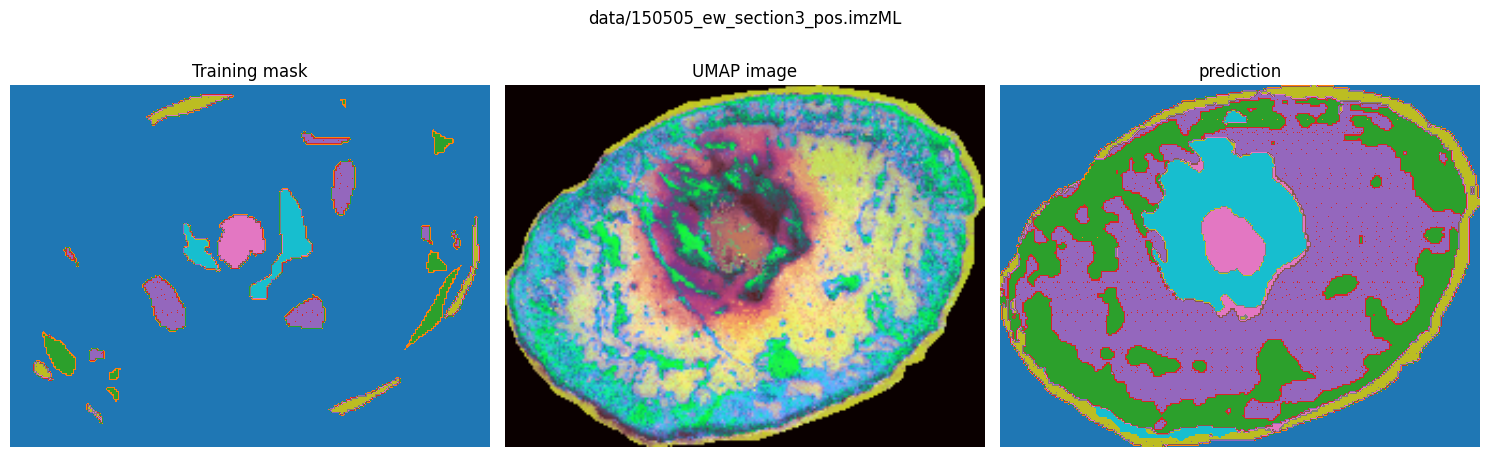

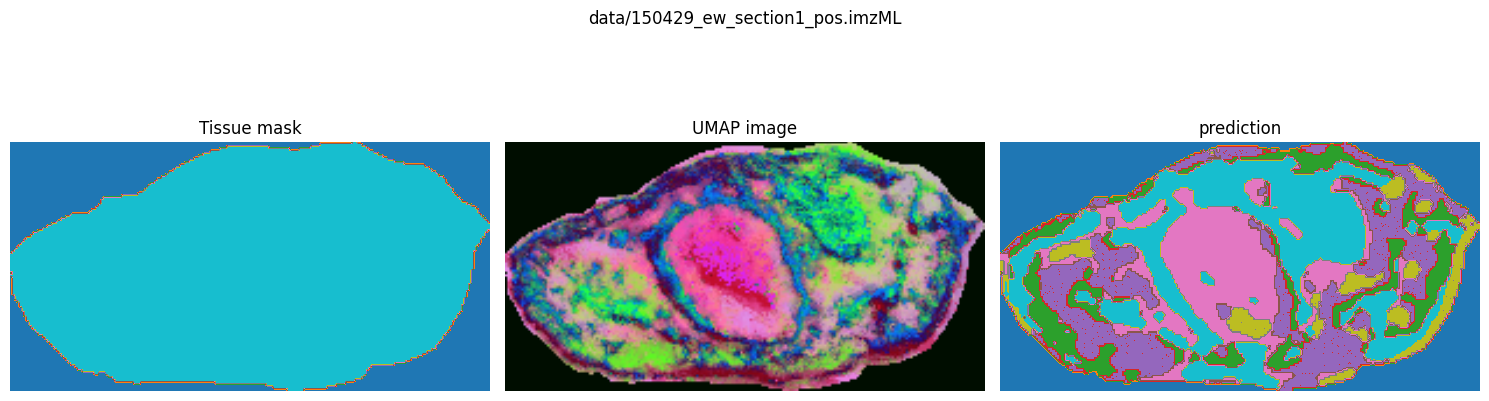

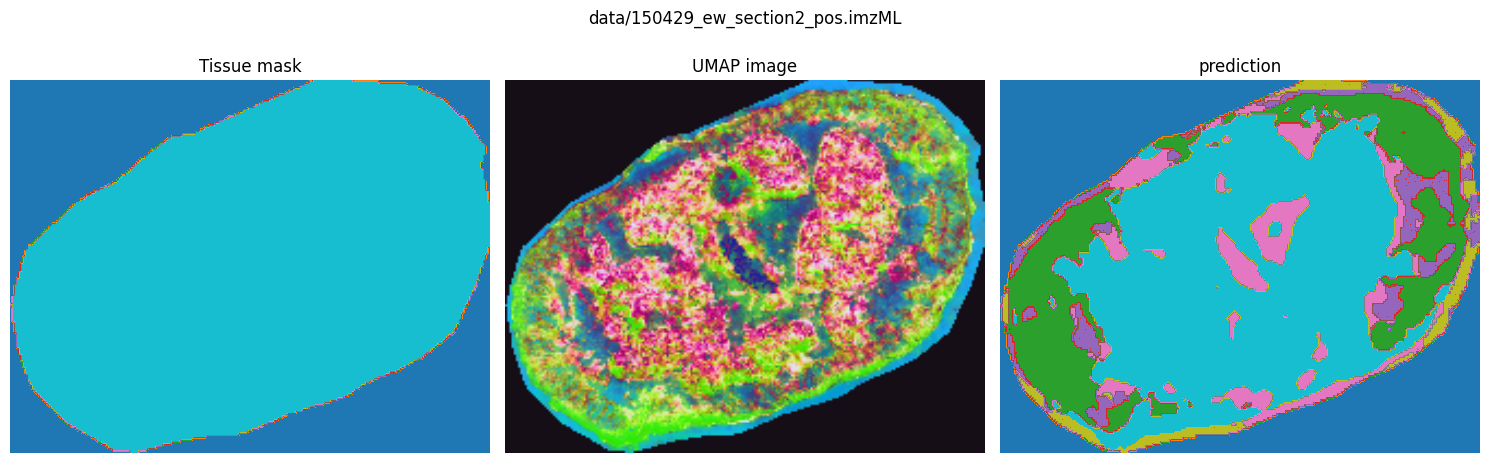

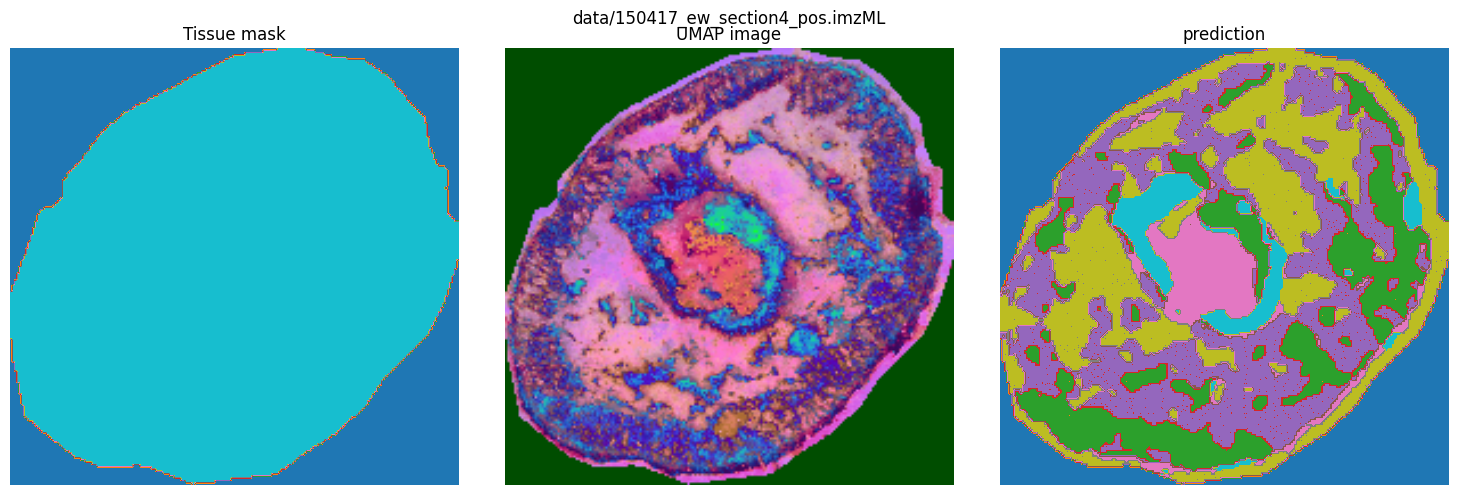

In [30]:
# visualize results and training data

import importlib
import Example_VII_Helpers
importlib.reload(Example_VII_Helpers)
from Example_VII_Helpers import show_images_in_row, overlay_images, label_map_to_rgb
umap_images = ["data/150429_ew_section1_pos_umap.nrrd", "data/150429_ew_section2_pos_umap.nrrd", "data/150417_ew_section4_pos_umap.nrrd", "data/150505_ew_section3_pos_umap.nrrd"]

# M = train_images[0].GetMaskArray()[0]
training_mask = labels_array.copy()[0]
training_mask = training_mask.astype(np.int32)

ionImage = train_images[0].GetIndexArray()[0]
ionImage = ionImage == ionImage[training_mask > 0][100]

umap_image = sitk.ReadImage(umap_images[-1])
umap_array = sitk.GetArrayFromImage(umap_image) # convert itk image to numpy array
umap_array[...,0] = (umap_array[...,0]-np.min(umap_array[...,0]))/np.max(umap_array[...,0]-np.min(umap_array[...,0]))
umap_array[...,1] = (umap_array[...,1]-np.min(umap_array[...,1]))/np.max(umap_array[...,1]-np.min(umap_array[...,1]))
umap_array[...,2] = (umap_array[...,2]-np.min(umap_array[...,2]))/np.max(umap_array[...,2]-np.min(umap_array[...,2]))


section_images = [training_mask, umap_array[0], test_image_results[-1]]
fig = show_images_in_row(section_images, ["Training mask", "UMAP image", "prediction"], ['tab10', None, 'tab10'])
fig.suptitle(train_file[0])
fig.tight_layout()

for i in range(3):
    umap_image = sitk.ReadImage(umap_images[i])
    umap_array = sitk.GetArrayFromImage(umap_image) # convert itk image to numpy array
    umap_array[...,0] = (umap_array[...,0]-np.min(umap_array[...,0]))/np.max(umap_array[...,0]-np.min(umap_array[...,0]))
    umap_array[...,1] = (umap_array[...,1]-np.min(umap_array[...,1]))/np.max(umap_array[...,1]-np.min(umap_array[...,1]))
    umap_array[...,2] = (umap_array[...,2]-np.min(umap_array[...,2]))/np.max(umap_array[...,2]-np.min(umap_array[...,2]))
    
    section_images = [test_images[i].GetMaskArray()[0], umap_array[0], test_image_results[i]]
    fig = show_images_in_row(section_images, ["Tissue mask", "UMAP image", "prediction"], ['tab10', None, 'tab10'])
    fig.suptitle(test_files[i])
    fig.tight_layout()
